# CSE 5525 Lab3
## Xuecheng Liu

Before running this notebook, please import the digit data to properiate folder.

For a), the following block will include the DTW implementation according to the hands-on and distance metrics.

In [64]:
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt 
import numpy.fft as npfft 
import IPython

In [65]:
def dist(x,y):
  return np.linalg.norm(x-y)

def dtw(x, y, dist):
    m = len(x)
    n = len(y)
    D = np.zeros((m, n))
    D[0,1:] = np.inf
    D[1:,0] = np.inf
    for i in range(m):
        for j in range(n):
            D[i, j] = min([D[i-1, j], D[i-1, j-1], D[i,j-1]]) + dist(x[i], y[j])
    return D[-1, -1]

The next step is to get the wave data and convert them into log mel spectral representations. The code is provided in Spectrogram Hands-on.

In [66]:
def linear2mel(freq):
  #B(f) = 1125 ln (1+f/700)
  return 1125 * np.log(1+freq/700)

def mel2linear(freq):
  #B^-1(b) = 700(e^(b/1125)-1)
  return 700*(np.exp(freq/1125)-1)

def melfb_boundaries(sf,n_fb):
  f1=0
  b1=linear2mel(f1)
  fh=sf/2
  bh=linear2mel(fh)
  return mel2linear(b1+np.arange(0,n_fb+1)*(bh-b1)/n_fb)

def melfilterbanks(sf,n_fb,nbin):
  freq=np.arange(0,sf,sf/nbin)
  melf_bins=melfb_boundaries(sf,n_fb+2)*nbin/(sf/2)
  H=np.zeros((n_fb,nbin))
  for flt in np.arange(1,n_fb+1):
    center=melf_bins[flt]
    prevbin=melf_bins[flt-1]
    nextbin=melf_bins[flt+1]
    k=np.arange(int(np.ceil(prevbin)),int(np.floor(center))+1)
    #print(k)
    H[flt-1,k]= 2*(k-prevbin)/((nextbin-prevbin)*(center-prevbin))
    k=np.arange(int(np.ceil(center)),int(np.floor(nextbin))+1)
    #print(k)
    H[flt-1,k]= 2*(nextbin-k)/((nextbin-prevbin)*(nextbin-center))
  return H.T


def melfilterbank_wave(wavefile, stepsize=0.01, windowsize=0.025):
  (sf,x)=scipy.io.wavfile.read(wavefile)
  winsize=int(sf*windowsize)  # windowsize in sec, sf in samples/sec
  shift=int(sf*stepsize)      # stepsize in sec, sf in samples/sec
  starts=np.arange(0,x.shape[-1]-winsize,shift) 
  # note here that we're going to get rid of higher half of frequencies
  L=np.zeros([starts.shape[-1],winsize//2],dtype=float)
  hamming=np.hamming(winsize)
  for c in np.arange(0,starts.shape[-1]): 
    start=starts[c]
    X=npfft.fft(x[start:start+winsize]*hamming)
    # remove frequencies above nyquist
    X=X[0:X.shape[-1]//2] 
    L[c,:]=np.log(X.real**2+X.imag**2)
  m=melfilterbanks(sf,40,winsize//2)
  return np.dot(L,m)

Here, variable x is the spectrol representation of wave 1a

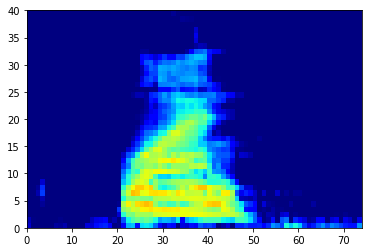

In [73]:
x = melfilterbank_wave('1a.wav')
plt.pcolormesh(x.transpose(),cmap='jet',vmin=10,vmax=25)

Next I would choose to compare scores of 1a and 1b v.s scores of 1a and 2a

In [77]:
y = melfilterbank_wave('1b.wav')
z = melfilterbank_wave('2a.wav')
D1= dtw(x,y,dist)
D2 = dtw(x,z,dist)

print("Scores between 1a and 1b is ",D1)
print("Scores between 1a and 2a is ",D2)

Scores between 1a and 1b is  555.177812881349
Scores between 1a and 2a is  834.0703264413027


Clearly, scores between matched pairs and smaller, which makes sense since they are similar.

Now the next step is to build a classifier using "a" version wave files as templetes and "b" versions as tests

The general approach would be for a given wave, compute its distance with all the "a" versions waves and pick the smallest one.

In [83]:
templetes = ["1a","2a","3a","4a","5a","6a","7a","8a","9a","oa","za"]
tests = ["1b","2b","3b","4b","5b","6b","7b","8b","9b","ob","zb"]
label = ["1","2","3","4","5","6","7","8","9","o","z"]

In [95]:
temp = [] # list contains all "a" version waves
for i in range(11): # list contains all "b" version waves
  temp.append(melfilterbank_wave(templetes[i]+'.wav'))

test = []
for i in range(11):
  test.append(melfilterbank_wave(tests[i]+'.wav'))

In [106]:
predictions = []
for i in range(11):
  scores = []
  for j in range(11):
    scores.append(dtw(test[i],temp[j],dist)) # for a given test, compare with all temps
  predictions.append(label[scores.index(min(scores))])



In [107]:
predictions

['1', '2', '3', '4', '5', '2', '7', '8', '9', 'o', 'z']

In [114]:
err = 0
for i in range(11):
  if predictions[i] != label[i]:
    err = err +1
(11 - err)*100/11 # accuracy

90.9090909090909

In summary, we have around 91% accuracy in predicting the labels.